# This is a notebook about predicting aurora

# 0. Data Downloading

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scripts.plotting import *

In [2]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, seasonal_plot, month_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})

In [3]:
# Downloading Kp Index data from https://www.gfz-potsdam.de/
from getKpindex import getKpindex

kpindex_data = getKpindex(starttime="1932-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), index="Kp")

# 1. Exploratory Data Analysis

## 1.1 Data Loading and Cleaning
Let's first take a look at the dataset. Clean it if necessary, and try to make sense of the data. 

In [4]:
# Since kpindex_data is a transposed 2D list or array, transpose it back to the correct format.
kpindex_data_transposed = list(zip(*kpindex_data))

# Convert to a DataFrame
kpindex_df = pd.DataFrame(kpindex_data_transposed, columns=["Datetime", "Kp_Index", "Status"])

# Convert 'Datetime' to pandas datetime object
kpindex_df['Datetime'] = pd.to_datetime(kpindex_df['Datetime'])

kpindex_df.head()

,Datetime,Kp_Index,Status
0,1932-01-01 00:00:00+00:00,3.333,def
1,1932-01-01 03:00:00+00:00,2.667,def
2,1932-01-01 06:00:00+00:00,2.333,def
3,1932-01-01 09:00:00+00:00,2.667,def
4,1932-01-01 12:00:00+00:00,3.333,def


In [5]:
# Check for any missing data
kpindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270944 entries, 0 to 270943
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  270944 non-null  datetime64[ns, UTC]
 1   Kp_Index  270944 non-null  float64            
 2   Status    270944 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 6.2+ MB


In [6]:
# Check for missing values
kpindex_df.isnull().sum()

Datetime    0
Kp_Index    0
Status      0
dtype: int64

In [7]:
kpindex_df.describe()

,Kp_Index
count,270944.000000
mean,2.169381
std,1.451569
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


There is a lot of data, from 1932 to present, and it's even broken into every 3 hours periods. Let's consolidate the data a little bit by taking the daily max Kp index, as we intend to predict Kp index for the next few days, not next few hours. 

In [8]:
# Create a new column for the date only
kpindex_df['Date'] = kpindex_df['Datetime'].dt.date

# Group by the 'Date' column and calculate the daily max and std of Kp index
daily_max_df = kpindex_df.groupby('Date').agg(Daily_Kp_max=('Kp_Index', 'max')).reset_index()

daily_max_df = pd.DataFrame(daily_max_df)

daily_max_df = daily_max_df.rename(columns={"Date": "Datetime", "Daily_Kp_max": "Kp_Index"})

daily_max_df.head()

,Datetime,Kp_Index
0,1932-01-01,3.333
1,1932-01-02,5.000
2,1932-01-03,3.333
3,1932-01-04,2.000
4,1932-01-05,2.000


In [9]:
daily_max_df.describe()

,Kp_Index
count,33868.000000
mean,3.385458
std,1.492857
min,0.000000
25%,2.333000
50%,3.333000
75%,4.333000
max,9.000000


There is three columns in the downloaded data, corresponding to the datetime of the record, the Kp index at the time, and whether it's a recorded or predicted value. There is no missing data in the datasets, so I won't need to perform any imputation. 

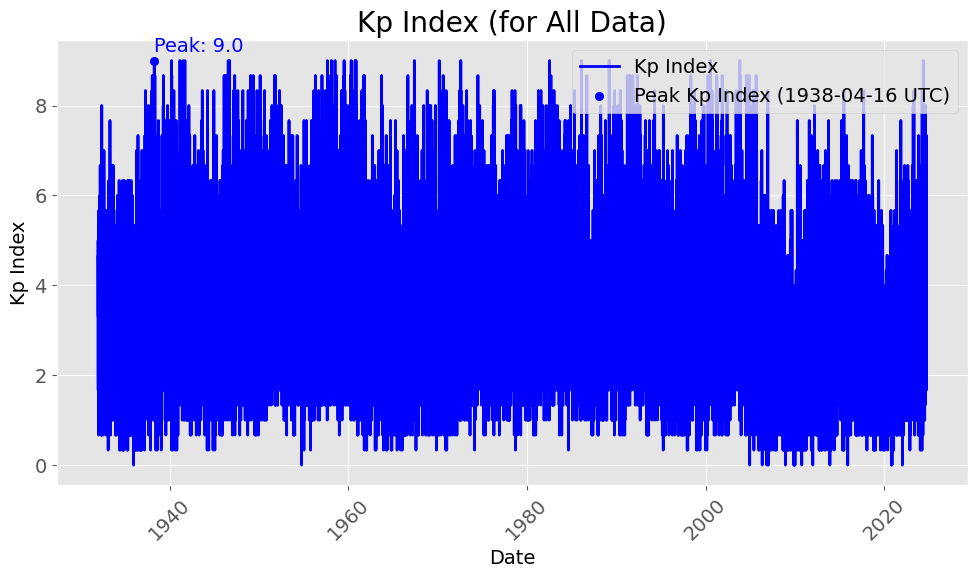

In [10]:
# To show all data:
plot_kp_index_by_date_range(daily_max_df)

This is a very large plot with many years of data. There doesn't seem to be an increase or decrease in max Kp index over the long timeframe, as suggested by an overall flat trend. 

Let's look at the annual max Kp index since 1932. 

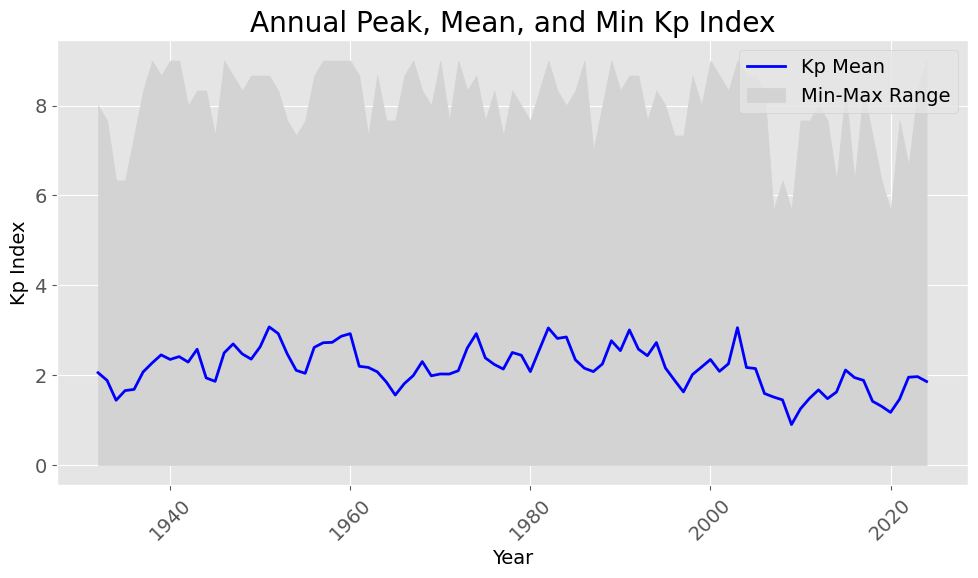

In [11]:
# Create a new column for the year
kpindex_df['Year'] = kpindex_df['Datetime'].dt.year

# Group by year and calculate max, min, and mean Kp index
annual_kp_df = kpindex_df.groupby('Year').agg(
    Kp_max=('Kp_Index', 'max'),
    Kp_min=('Kp_Index', 'min'),
    Kp_mean=('Kp_Index', 'mean')
).reset_index()

# Create a plot for the annual Kp Index (mean) with min-max range
plt.figure(figsize=(10, 6))

# Plot the mean Kp index
plt.plot(annual_kp_df['Year'], annual_kp_df['Kp_mean'], label="Kp Mean", color='blue')

# Fill between the min and max values to create a shaded area
plt.fill_between(annual_kp_df['Year'], annual_kp_df['Kp_min'], annual_kp_df['Kp_max'], color='lightgray', alpha=1, label="Min-Max Range")

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Kp Index')
plt.title("Annual Peak, Mean, and Min Kp Index")
plt.xticks(rotation=45)
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Between 1932 and 2024, the average annual Kp index doesn't seem to alter too much, but we can still observe a recent dip between 2009 and 2012, in both the max and mean Kp indices. This could be attributed to both technological reasons such as changing of the surveillance monitors or environmental reasons such as decreases in solar activities. 

For our downstream analysis, since we have an over-abundance of data, let's start by analyzing the data since 2000. This both alleviates the burden on our pipeline to take in all data and reduces the measurement errors attributed to different versions of monitors. 

In [12]:
# Filter the data for entries after 2000-01-01
daily_max_df_2000 = daily_max_df[daily_max_df['Datetime'] >= '2000-01-01'].reset_index(drop=True)

daily_max_df_2000.head()

,Datetime,Kp_Index
0,2000-01-01,5.333
1,2000-01-02,3.333
2,2000-01-03,3.333
3,2000-01-04,3.667
4,2000-01-05,4.000


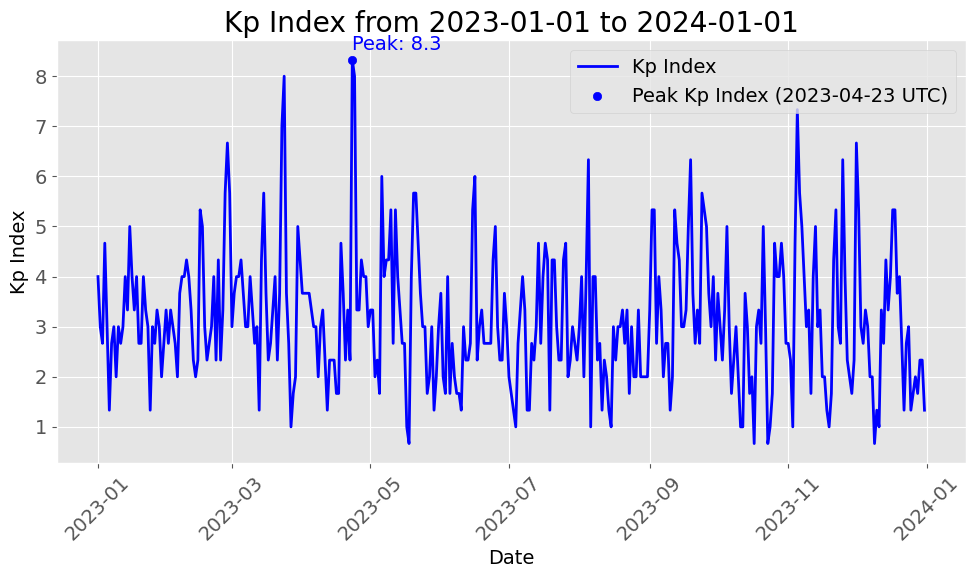

In [13]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2023-01-01', '2024-01-01')

There are ups and downs in the Kp Index but overall there isn't a upward or downward trend. 

Let's look at the past month only (August 2024). 

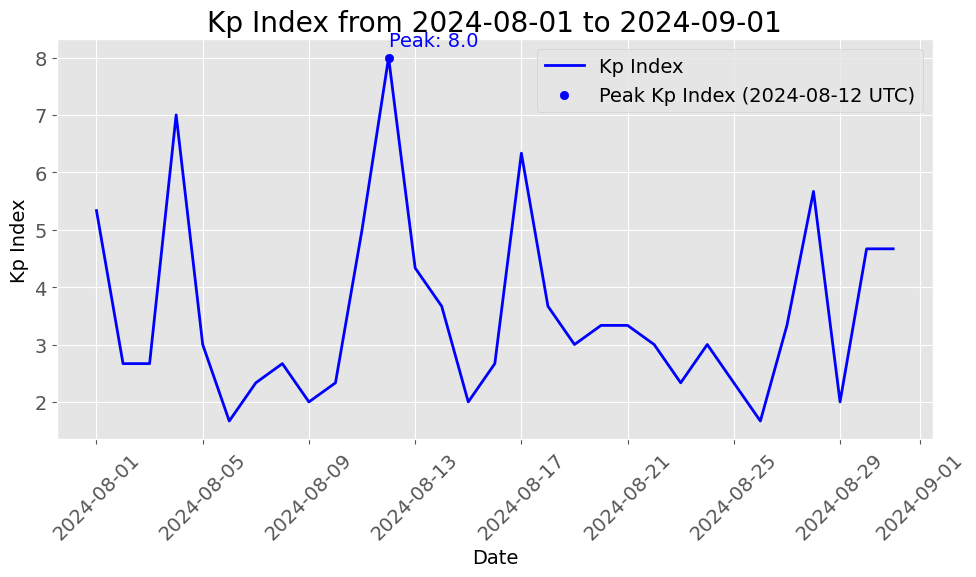

In [14]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2024-08-01', '2024-09-01')

Looks like there are variations of different widths. I personally was able to see aurora borealis on August 12th, 2024, which had the peak in Kp index. 

I saw another one in May 2024. Let's see if we can find it using the plot.

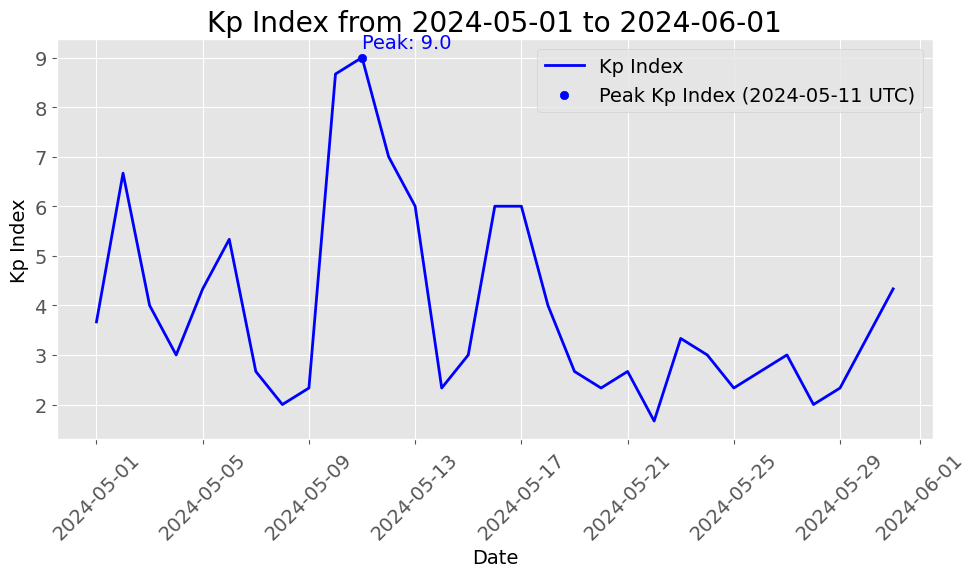

In [15]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2024-05-01', '2024-06-01')

What about in September 2024?

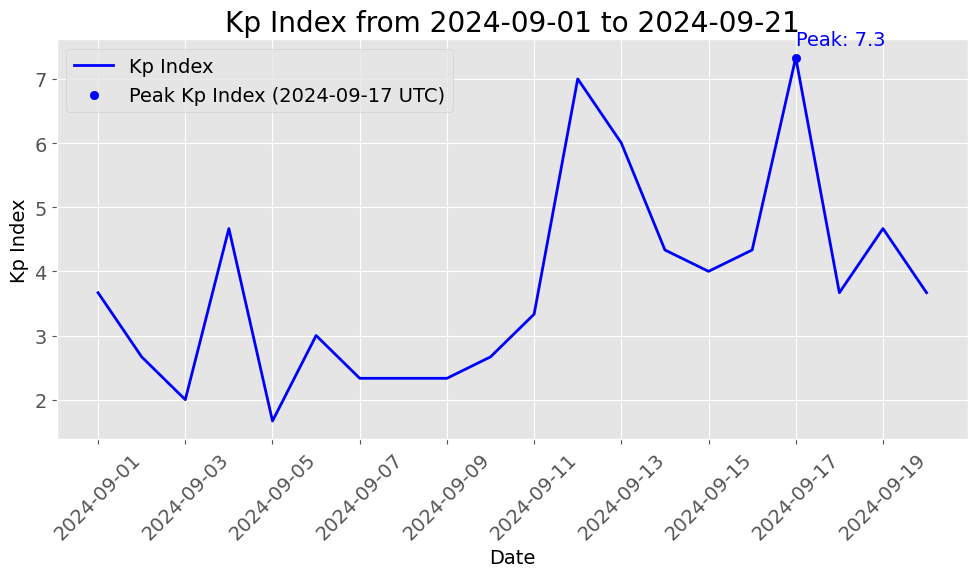

In [16]:
# To show data for August 2024:
plot_kp_index_by_date_range(daily_max_df_2000, '2024-09-01', '2024-09-21')

## 1.2 Trends
With a lot of time-series data, there are temporal dependence, which maxs the value at a time is dependent on the value in the past. I will now take a look at this dependence, which is also called "autocorrelation". 

Firstly, let's examine if there are trends over the years. I'm going to try the polynomial with orders 0, 1, and 3 to try to capture the trend.

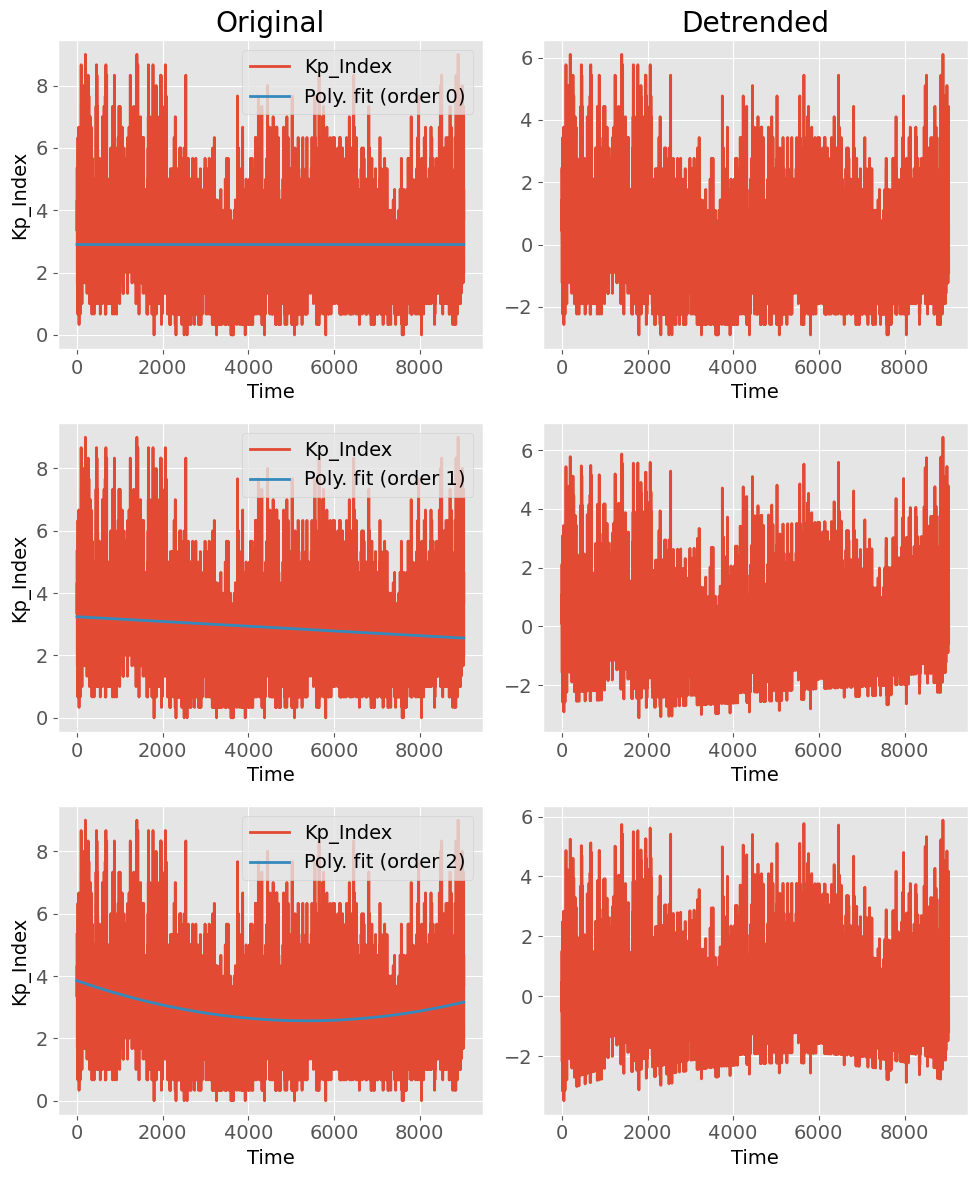

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for order in range(3):
    fit_label = f"Poly. fit (order {order})"
    daily_max_df_2000[fit_label] = daily_max_df_2000["Kp_Index"] - detrend(daily_max_df_2000["Kp_Index"], order=order)
    daily_max_df_2000[["Kp_Index", fit_label]].plot.line(xlabel="Time", ylabel="Kp_Index", ax=axes[order, 0])
    (daily_max_df_2000["Kp_Index"] - daily_max_df_2000[fit_label]).plot.line(xlabel="Time", legend=False, ax=axes[order, 1])
axes[0, 0].set_title("Original")
axes[0, 1].set_title("Detrended")
plt.tight_layout();

Looks like the polynomial fit of order 0 is already working pretty well. I guess the data over the entire period of time isn't increaseing or decreasing. The lines oscillates around Kp_Index of `2.8987793`, as indicated in the `Poly. fit (order 0)`. We can use detrending to remove this. 

In [18]:
daily_max_df_2000['detrended'] = daily_max_df_2000["Kp_Index"] - daily_max_df_2000['Poly. fit (order 0)']
daily_max_df_2000.head()

,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended
0,2000-01-01,5.333,2.898793,3.241406,3.848754,2.434207
1,2000-01-02,3.333,2.898793,3.241330,3.848274,0.434207
2,2000-01-03,3.333,2.898793,3.241254,3.847795,0.434207
3,2000-01-04,3.667,2.898793,3.241178,3.847316,0.768207
4,2000-01-05,4.000,2.898793,3.241102,3.846837,1.101207


By subtracting all daily values with `2.898793`, the lines should converge to 0, shown by the detrended polynomial 0 graph (top right). 

## 1.3 Seasonality

Let's do some exploration first. I'm curious to see how the peak Kp index repeat over days in a month, and months in a year and .

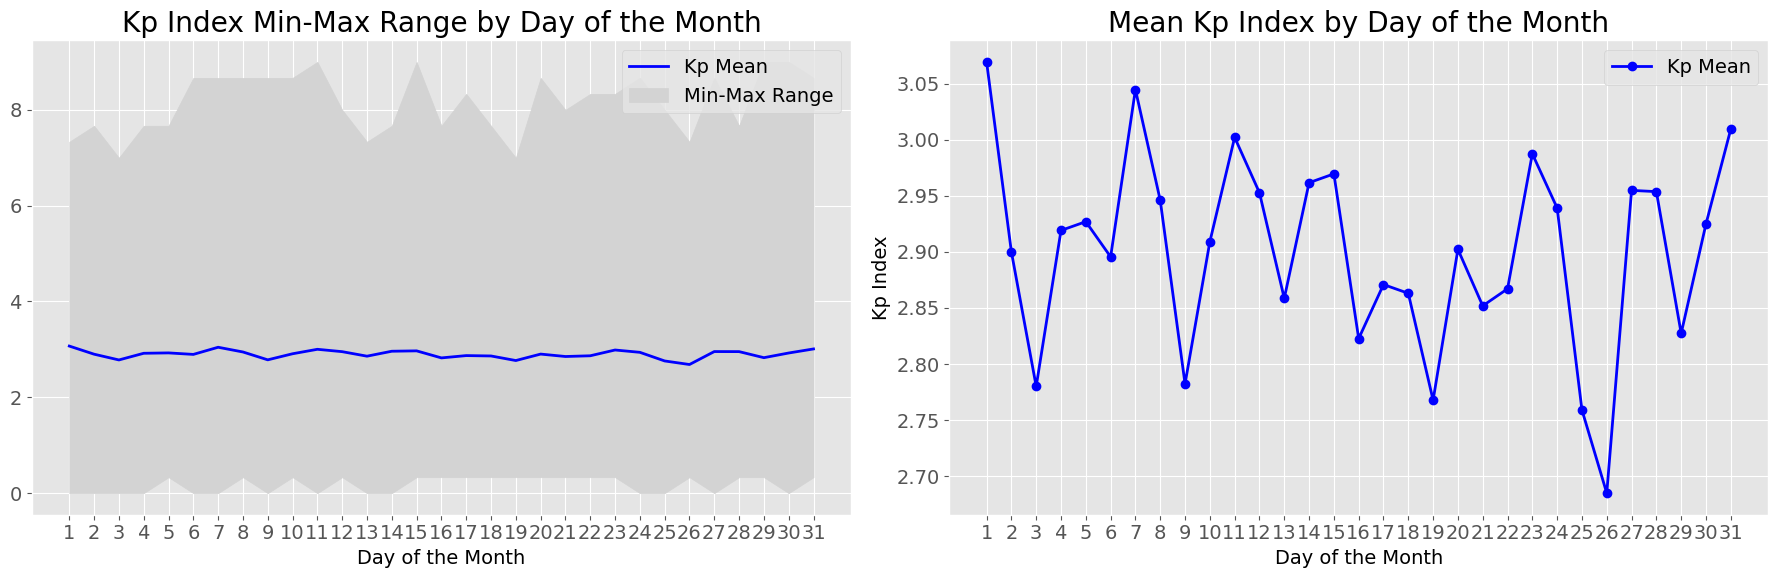

In [19]:
# Group by day of the month and calculate the mean, min, and max
day_of_month = daily_max_df_2000.groupby(daily_max_df_2000['Datetime'].dt.day).agg(
    Mean_dayofmonth_peak_Kp=('Kp_Index', 'mean'), 
    Min_dayofmonth_peak_Kp=('Kp_Index', 'min'), 
    Max_dayofmonth_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Rename the 'Datetime' column to 'Day' since we are grouping by the day of the month
day_of_month.rename(columns={'Datetime': 'Day_of_Month'}, inplace=True)

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(day_of_month['Day_of_Month'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(day_of_month['Day_of_Month'], day_of_month['Min_dayofmonth_peak_Kp'], day_of_month['Max_dayofmonth_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Day of the Month')
axes[0].set_title("Kp Index Min-Max Range by Day of the Month")
axes[0].set_xticks(range(1, 32))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(day_of_month['Day_of_Month'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Day of the Month")
axes[1].set_xticks(range(1, 32))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see the variation for day of a month is not too striking. Although the right graph showed ups and downs, keep in mind of the y axis. 

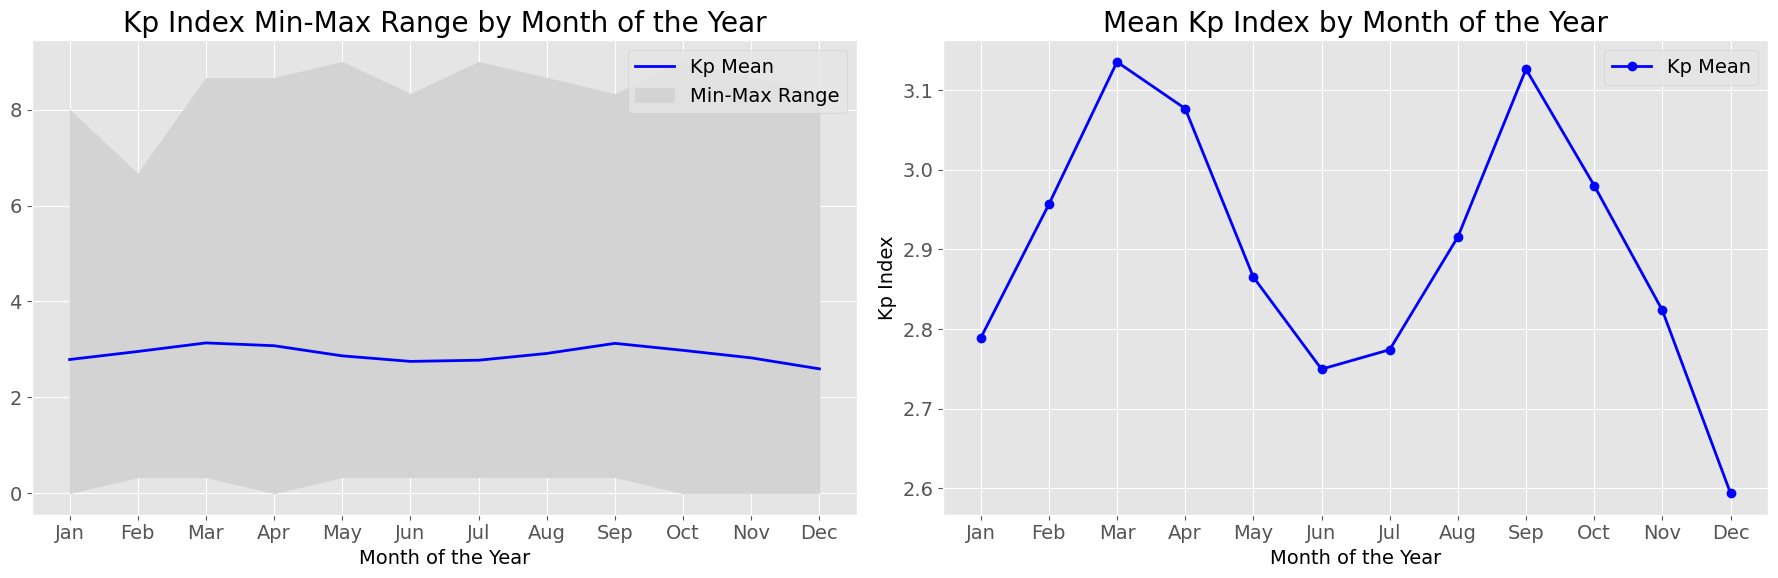

In [20]:
# Group by month of the year and calculate the mean, min, and max
month_of_year = daily_max_df_2000.groupby(daily_max_df_2000['Datetime'].dt.month).agg(
    Mean_monthly_peak_Kp=('Kp_Index', 'mean'), 
    Min_monthly_peak_Kp=('Kp_Index', 'min'), 
    Max_monthly_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Rename the 'Datetime' column to 'Month' since we are grouping by the month of the year
month_of_year.rename(columns={'Datetime': 'Month'}, inplace=True)

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(month_of_year['Month'], month_of_year['Min_monthly_peak_Kp'], month_of_year['Max_monthly_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Month of the Year')
axes[0].set_title("Kp Index Min-Max Range by Month of the Year")
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[0].legend()

# Plot mean Kp index
axes[1].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Month of the Year')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Month of the Year")
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see that for months in a year, the Kp index varies a bit more than days of a month. It tends to peak during March and September, and dips around between June to July and December to January. 

Let's save both month of a year and day of a month as additional features in the dataframe. 

In [23]:
daily_max_df_2000 = daily_max_df_2000.merge(day_of_month, left_on=daily_max_df_2000['Datetime'].dt.day, right_on='Day_of_Month', how='left')
daily_max_df_2000 = daily_max_df_2000.merge(month_of_year, left_on=daily_max_df_2000['Datetime'].dt.month, right_on='Month', how='left')

daily_max_df_2000.head()

,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended,Day_of_Month,Mean_dayofmonth_peak_Kp,Min_dayofmonth_peak_Kp,Max_dayofmonth_peak_Kp,Month,Mean_monthly_peak_Kp,Min_monthly_peak_Kp,Max_monthly_peak_Kp
0,2000-01-01,5.333,2.898793,3.241406,3.848754,2.434207,1,3.069596,0.000,7.333,1,2.788832,0.0,8.0
1,2000-01-02,3.333,2.898793,3.241330,3.848274,0.434207,2,2.900118,0.000,7.667,1,2.788832,0.0,8.0
2,2000-01-03,3.333,2.898793,3.241254,3.847795,0.434207,3,2.780020,0.000,7.000,1,2.788832,0.0,8.0
3,2000-01-04,3.667,2.898793,3.241178,3.847316,0.768207,4,2.919199,0.000,7.667,1,2.788832,0.0,8.0
4,2000-01-05,4.000,2.898793,3.241102,3.846837,1.101207,5,2.927017,0.333,7.667,1,2.788832,0.0,8.0


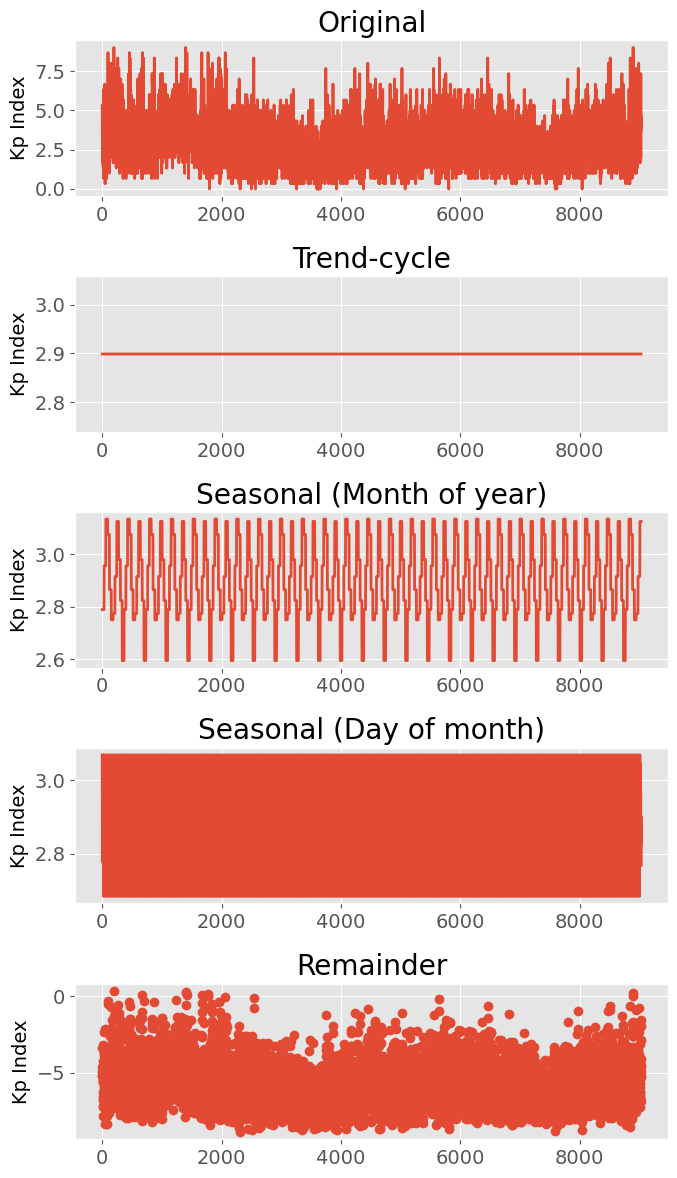

In [24]:
# Estimating the remainder
daily_max_df_2000["remainder"] = daily_max_df_2000["Kp_Index"] - daily_max_df_2000["Poly. fit (order 0)"] - daily_max_df_2000["Mean_monthly_peak_Kp"] - daily_max_df_2000["Mean_dayofmonth_peak_Kp"]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(7, 12))
daily_max_df_2000["Kp_Index"].plot.line(ylabel="Kp Index", title="Original", xlabel="", ax=axes[0])
daily_max_df_2000["Poly. fit (order 0)"].plot.line(ylabel="Kp Index", title="Trend-cycle", xlabel="", ax=axes[1])
daily_max_df_2000["Mean_monthly_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Month of year)", xlabel="", ax=axes[2])
daily_max_df_2000["Mean_dayofmonth_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Day of month)", xlabel="", ax=axes[3])
daily_max_df_2000["remainder"].plot.line(ylabel="Kp Index", title="Remainder", ax=axes[4], marker="o", linestyle="")
plt.tight_layout();

We can see that the remainder doesn't look very stationary after the deletions. 

The next tool we have in testing for seasonality is using the autocorrelation function `acf` and `pacf`. It looks for any correlations in the time-series data. 

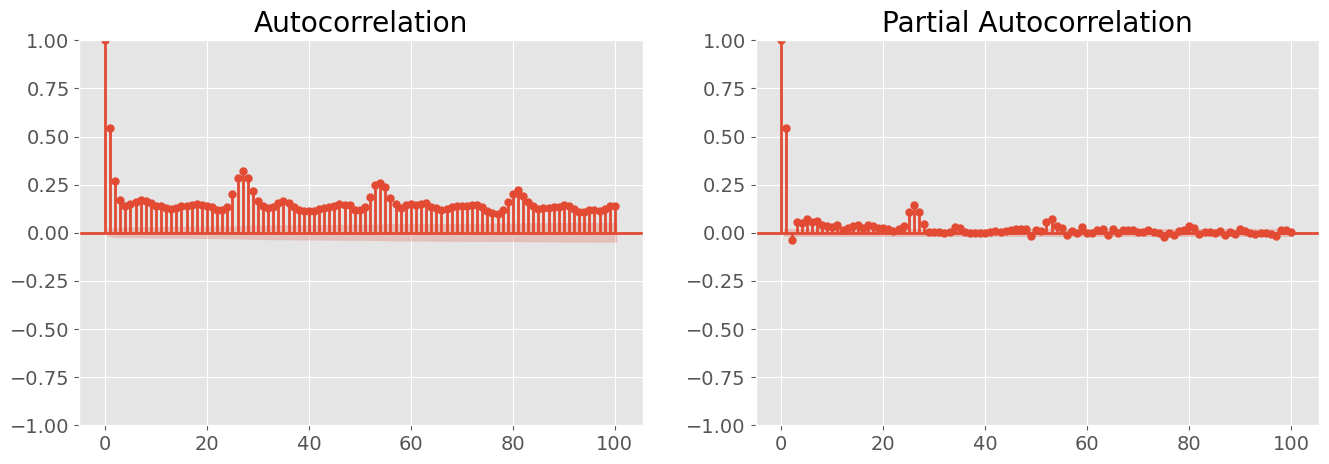

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(daily_max_df_2000["remainder"], lags=100, ax=axes[0])
plot_pacf(daily_max_df_2000["remainder"], lags=100, ax=axes[1]);

There is autocorrelation around every 25-30 lags. Maybe this correlates with the cycle of the Sun (the Sun rotates on its axis once in 27 days)? 

Since the ACF value drops rapidly after lag 3, the autocorrelation is very strong.

Let's extract the exact lag value first. 

In [26]:
acf_data = acf(daily_max_df_2000["Kp_Index"], nlags=100, bartlett_confint=True)

# Create lags array
lags = np.arange(len(acf_data))

# Define the range to find the highest point
start_lag = 20
end_lag = 40

# Find indices within the specified lag range
indices_within_range = np.where((lags >= start_lag) & (lags <= end_lag))[0]

# Find the maximum ACF value within this range
max_index = indices_within_range[np.argmax(acf_data[indices_within_range])]
max_lag = lags[max_index]
max_acf_value = acf_data[max_index]

print(f'The maximum ACF value is at lag {max_lag} with a value of {max_acf_value}.')

The maximum ACF value is at lag 27 with a value of 0.32367859792626685.


I can label this onto the ACF plot. 

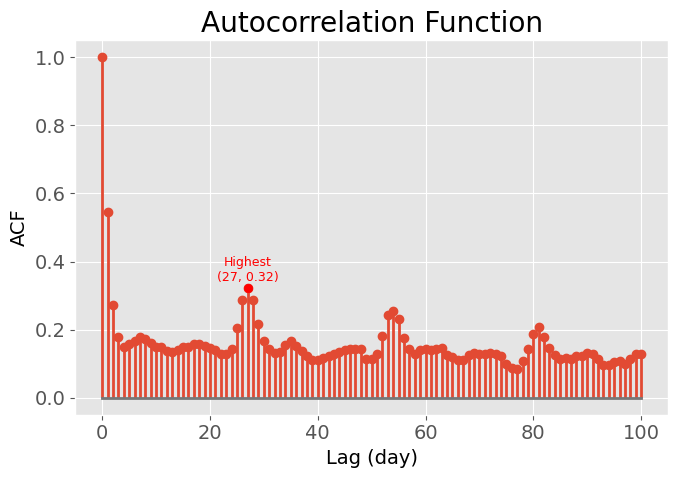

In [27]:
# Plot ACF
plt.stem(lags, acf_data, use_line_collection=True)
plt.xlabel("Lag (day)")
plt.ylabel('ACF')

# Annotate the highest point
plt.scatter(max_lag, max_acf_value, color='red', zorder=5)
plt.text(max_lag, max_acf_value + 0.02, f'Highest\n({max_lag}, {max_acf_value:.2f})',
         color='red', fontsize=9, ha='center')

plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

Let's explore how the Kp index repeats every 27 days.

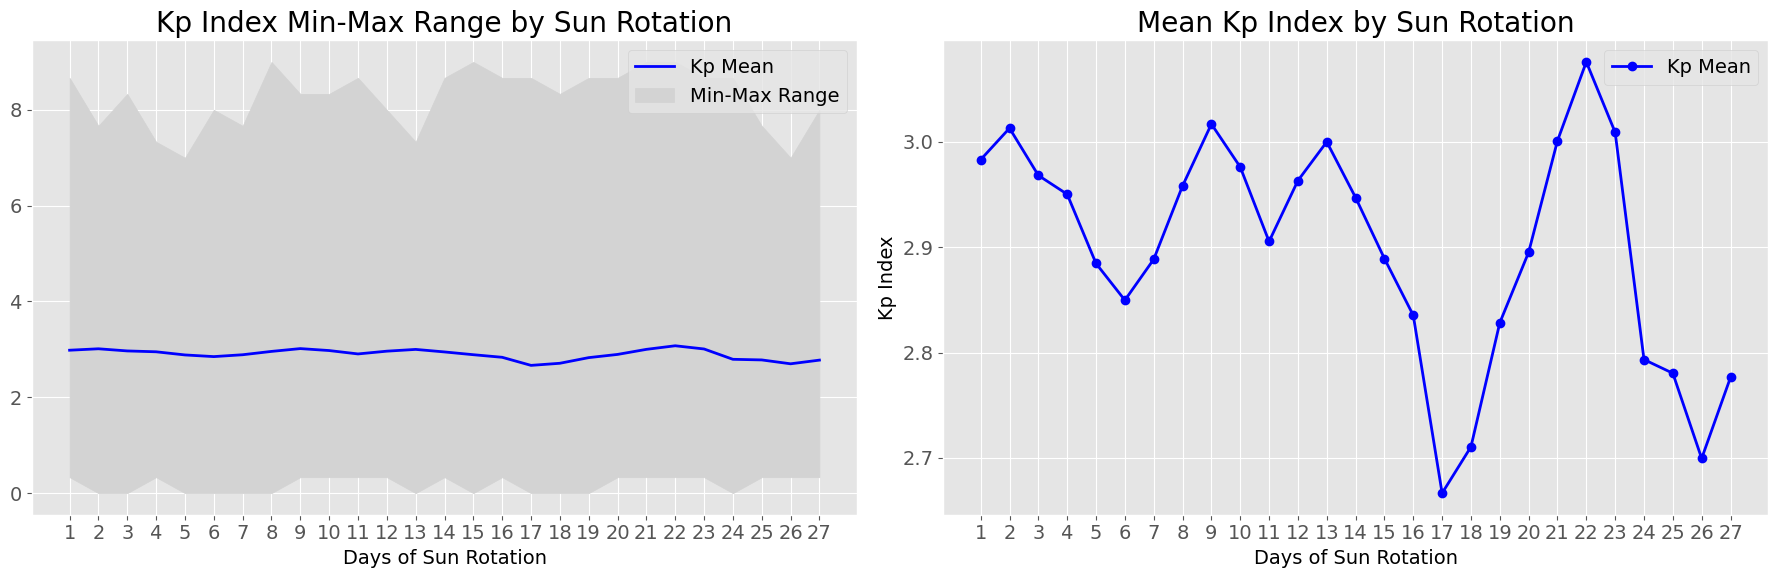

In [28]:
# Create a 27-day period identifier based on the day of the dataset
daily_max_df_2000['Day_Sun_rotation'] = daily_max_df_2000.index % 27 +1  # Grouping every 27 days
sun_rotation = daily_max_df_2000.groupby(daily_max_df_2000['Day_Sun_rotation']).agg(
    Mean_sunrotation_peak_Kp=('Kp_Index', 'mean'), 
    Min_sunrotation_peak_Kp=('Kp_Index', 'min'), 
    Max_sunrotation_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(sun_rotation['Day_Sun_rotation'], sun_rotation['Mean_sunrotation_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(sun_rotation['Day_Sun_rotation'], sun_rotation['Min_sunrotation_peak_Kp'], sun_rotation['Max_sunrotation_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Days of Sun Rotation')
axes[0].set_title("Kp Index Min-Max Range by Sun Rotation")
axes[0].set_xticks(range(1, 28))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(sun_rotation['Day_Sun_rotation'], sun_rotation['Mean_sunrotation_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Days of Sun Rotation')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Sun Rotation")
axes[1].set_xticks(range(1, 28))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


We can see that there are some variations of average Kp index in the 27 day period, especially a large variation between day 17 and 22. However, keep in mind of the scale of these changes, which is only from 2.6 to 3.2. 

There is also the solar cycle, which lasts for 11 years. Let's explore that

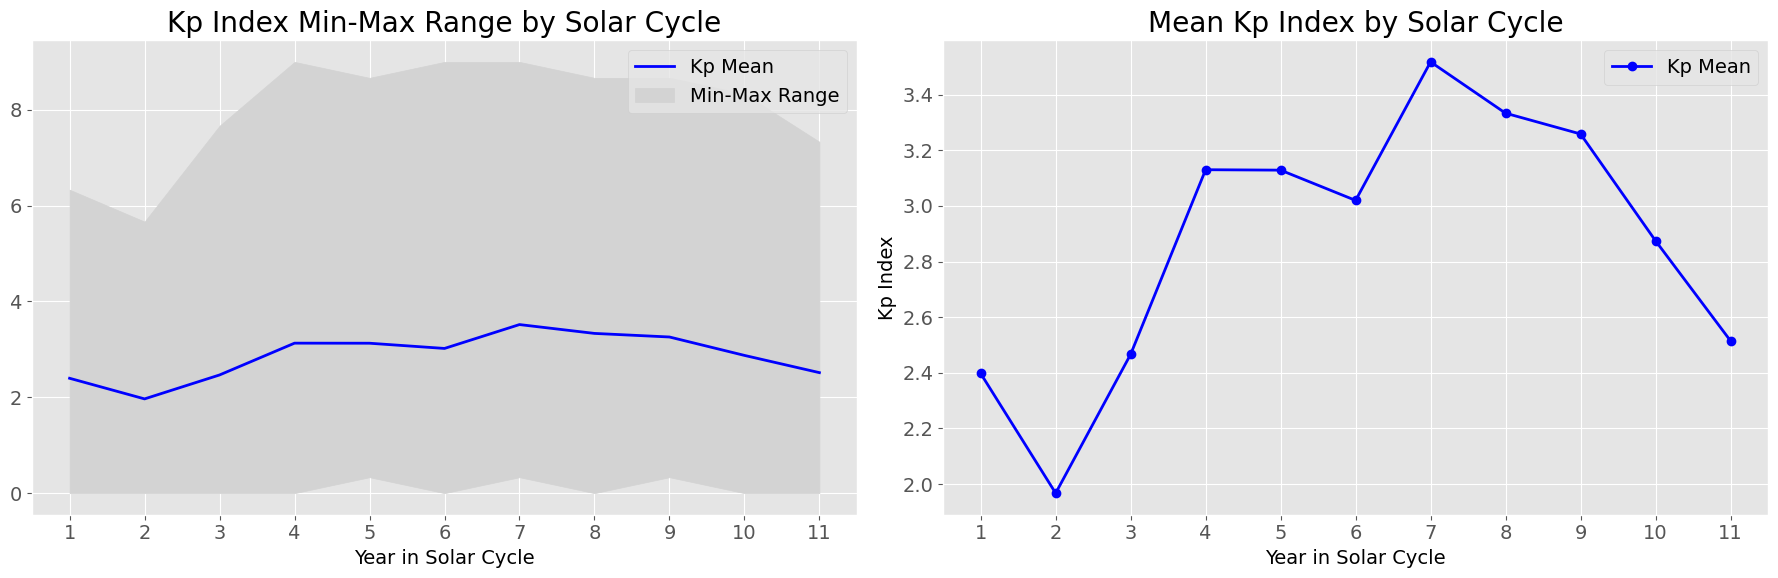

In [29]:
# Create an 11-year period identifier based on the year. As the first conventionally stated solar cycle began in 1755. 
# We subtract 1755 from each year to indicate which year is it at during a solar cycle. 
daily_max_df_2000['Year'] = daily_max_df_2000['Datetime'].dt.year
daily_max_df_2000['11_Year_Group'] = (daily_max_df_2000['Year'] - 1755) % 11 + 1

solar_cycle = daily_max_df_2000.groupby(daily_max_df_2000['11_Year_Group']).agg(
    Mean_solarcycle_peak_Kp=('Kp_Index', 'mean'), 
    Min_solarcycle_peak_Kp=('Kp_Index', 'min'), 
    Max_solarcycle_peak_Kp=('Kp_Index', 'max')
).reset_index()

# Create subplots with two side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot min, mean, max Kp index
axes[0].plot(solar_cycle['11_Year_Group'], solar_cycle['Mean_solarcycle_peak_Kp'], label="Kp Mean", color='blue')
axes[0].fill_between(solar_cycle['11_Year_Group'], solar_cycle['Min_solarcycle_peak_Kp'], solar_cycle['Max_solarcycle_peak_Kp'], color='lightgray', alpha=1, label="Min-Max Range")
axes[0].set_xlabel('Year in Solar Cycle')
axes[0].set_title("Kp Index Min-Max Range by Solar Cycle")
axes[0].set_xticks(range(1, 12))
axes[0].legend()

# Plot mean Kp index
axes[1].plot(solar_cycle['11_Year_Group'], solar_cycle['Mean_solarcycle_peak_Kp'], label="Kp Mean", color='blue', marker="o")
axes[1].set_xlabel('Year in Solar Cycle')
axes[1].set_ylabel('Kp Index')
axes[1].set_title("Mean Kp Index by Solar Cycle")
axes[1].set_xticks(range(1, 12))
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


The variations in mean solar cycle Kp are greater than that in the 27 day solar rolation, ranging between 2.0 to 3.5. Let's merge these two dataframes with the `daily_max_df_2000` and perform the manual removal of autocorrelation.

In [31]:
daily_max_df_2000 = daily_max_df_2000.merge(sun_rotation, left_on=daily_max_df_2000['Day_Sun_rotation'], right_on='Day_Sun_rotation', how='left')
daily_max_df_2000 = daily_max_df_2000.merge(solar_cycle, left_on=daily_max_df_2000['11_Year_Group'], right_on='11_Year_Group', how='left')

daily_max_df_2000.head()

,11_Year_Group,Day_Sun_rotation,Datetime,Kp_Index,Poly. fit (order 0),Poly. fit (order 1),Poly. fit (order 2),detrended,Day_of_Month,Mean_dayofmonth_peak_Kp,...,Year,11_Year_Group_x,Day_Sun_rotation_y,Mean_sunrotation_peak_Kp,Min_sunrotation_peak_Kp,Max_sunrotation_peak_Kp,11_Year_Group_y,Mean_solarcycle_peak_Kp,Min_solarcycle_peak_Kp,Max_solarcycle_peak_Kp
0,4,1,2000-01-01,5.333,2.898793,3.241406,3.848754,2.434207,1,3.069596,...,2000,4,1,2.983078,0.333,8.667,4,3.130476,0.0,9.0
1,4,2,2000-01-02,3.333,2.898793,3.241330,3.848274,0.434207,2,2.900118,...,2000,4,2,3.012973,0.000,7.667,4,3.130476,0.0,9.0
2,4,3,2000-01-03,3.333,2.898793,3.241254,3.847795,0.434207,3,2.780020,...,2000,4,3,2.968164,0.000,8.333,4,3.130476,0.0,9.0
3,4,4,2000-01-04,3.667,2.898793,3.241178,3.847316,0.768207,4,2.919199,...,2000,4,4,2.950257,0.333,7.333,4,3.130476,0.0,9.0
4,4,5,2000-01-05,4.000,2.898793,3.241102,3.846837,1.101207,5,2.927017,...,2000,4,5,2.884567,0.000,7.000,4,3.130476,0.0,9.0


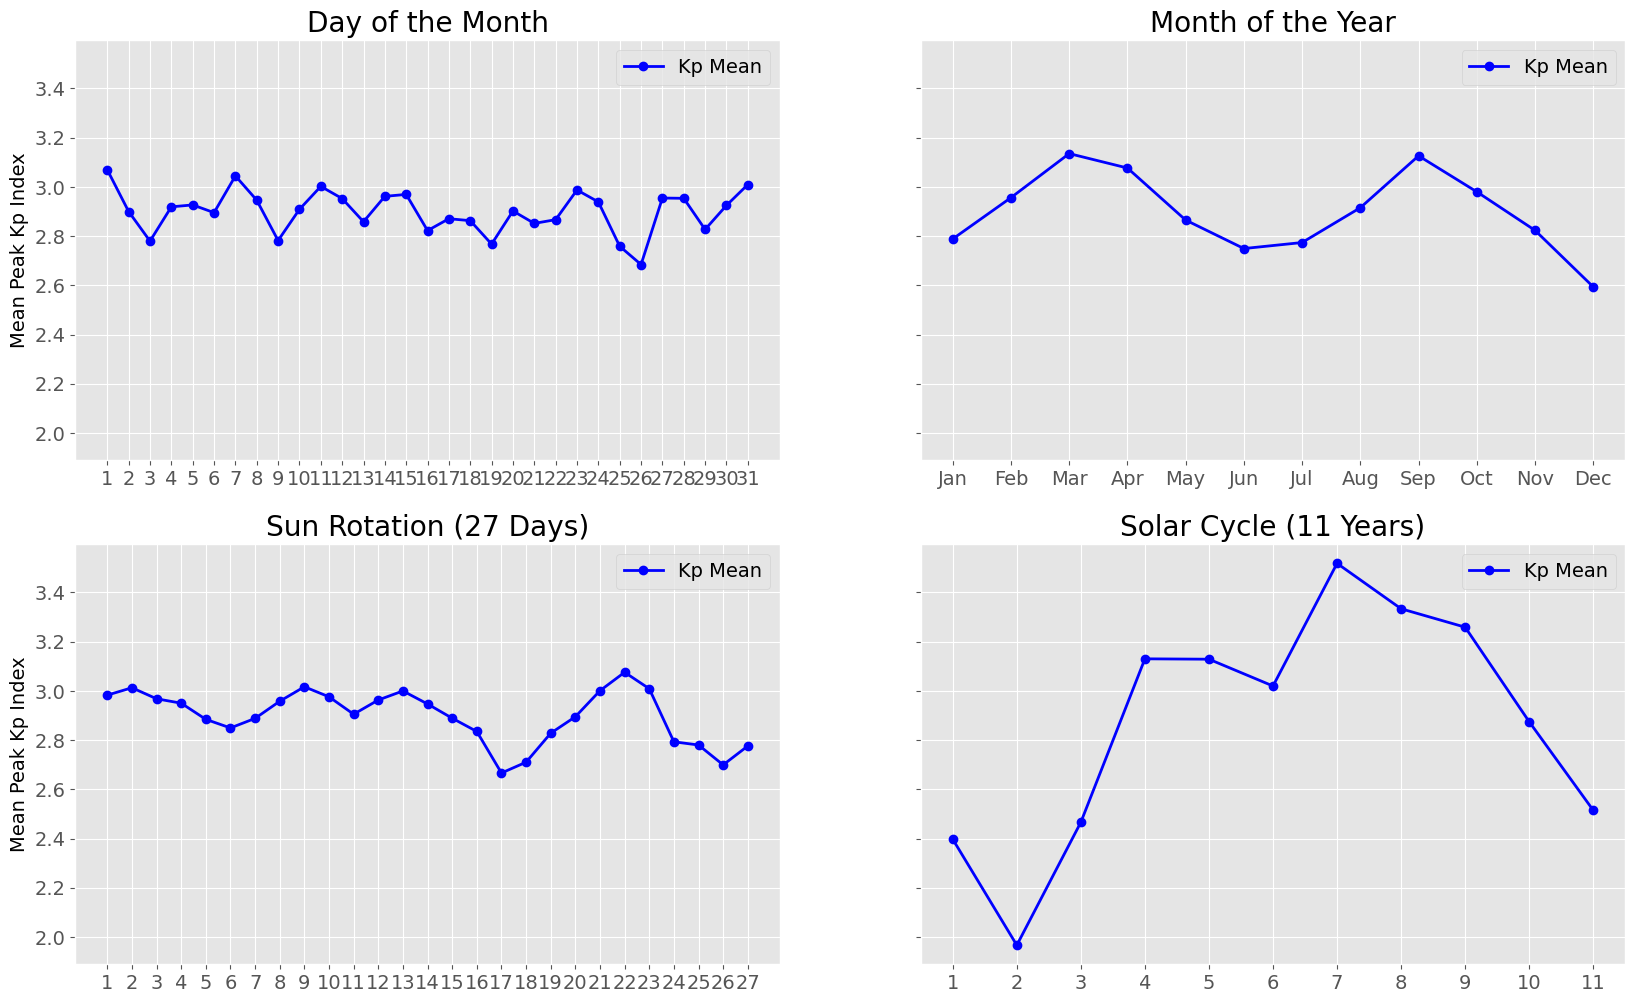

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharey='all')
# Plot mean Kp index
axes[0,0].plot(day_of_month['Day_of_Month'], day_of_month['Mean_dayofmonth_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[0,0].set_xlabel('Day of the Month')
axes[0,0].set_ylabel('Mean Peak Kp Index')
axes[0,0].set_title("Day of the Month")
axes[0,0].set_xticks(range(1, 32))
axes[0,0].legend()

# Plot mean Kp index
axes[0,1].plot(month_of_year['Month'], month_of_year['Mean_monthly_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[0,1].set_xlabel('Month of the Year')
# axes[0,1].set_ylabel('Kp Index')
axes[0,1].set_title("Month of the Year")
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels([
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
axes[0,1].legend()

# Plot mean Kp index
axes[1,0].plot(sun_rotation['Day_Sun_rotation'], sun_rotation['Mean_sunrotation_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[1,0].set_xlabel('Days of Sun Rotation')
axes[1,0].set_ylabel('Mean Peak Kp Index')
axes[1,0].set_title("Sun Rotation (27 Days)")
axes[1,0].set_xticks(range(1, 28))
axes[1,0].legend()


# Plot mean Kp index
axes[1,1].plot(solar_cycle['11_Year_Group'], solar_cycle['Mean_solarcycle_peak_Kp'], label="Kp Mean", color='blue', marker="o")
# axes[1,1].set_xlabel('Year in Solar Cycle')
# axes[1,1].set_ylabel('Kp Index')
axes[1,1].set_title("Solar Cycle (11 Years)")
axes[1,1].set_xticks(range(1, 12))
axes[1,1].legend()


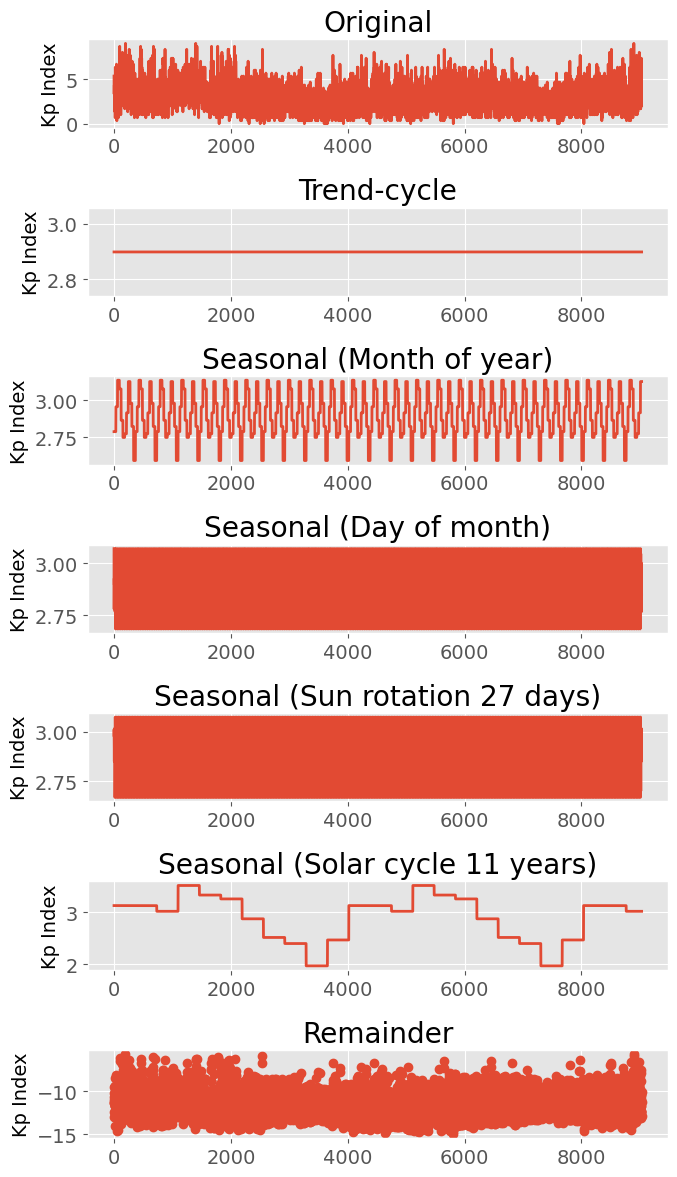

In [34]:
# Adding two more subtractions to the remainder
daily_max_df_2000["remainder"] = (
    daily_max_df_2000["Kp_Index"]
    - daily_max_df_2000["Poly. fit (order 0)"]
    - daily_max_df_2000["Mean_monthly_peak_Kp"]
    - daily_max_df_2000["Mean_dayofmonth_peak_Kp"]
    - daily_max_df_2000["Mean_sunrotation_peak_Kp"]
    - daily_max_df_2000["Mean_solarcycle_peak_Kp"]
)

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(7, 12))
daily_max_df_2000["Kp_Index"].plot.line(ylabel="Kp Index", title="Original", xlabel="", ax=axes[0])
daily_max_df_2000["Poly. fit (order 0)"].plot.line(ylabel="Kp Index", title="Trend-cycle", xlabel="", ax=axes[1])
daily_max_df_2000["Mean_monthly_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Month of year)", xlabel="", ax=axes[2])
daily_max_df_2000["Mean_dayofmonth_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Day of month)", xlabel="", ax=axes[3])
daily_max_df_2000["Mean_sunrotation_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Sun rotation 27 days)", xlabel="", ax=axes[4])
daily_max_df_2000["Mean_solarcycle_peak_Kp"].plot.line(ylabel="Kp Index", title="Seasonal (Solar cycle 11 years)", xlabel="", ax=axes[5])
daily_max_df_2000["remainder"].plot.line(ylabel="Kp Index", title="Remainder", ax=axes[6], marker="o", linestyle="")
plt.tight_layout();

After these detrending and deseasonality methods, the remainder looks much more stationary than before. 

Let's validate with the `acf` and `pacf` methods. 

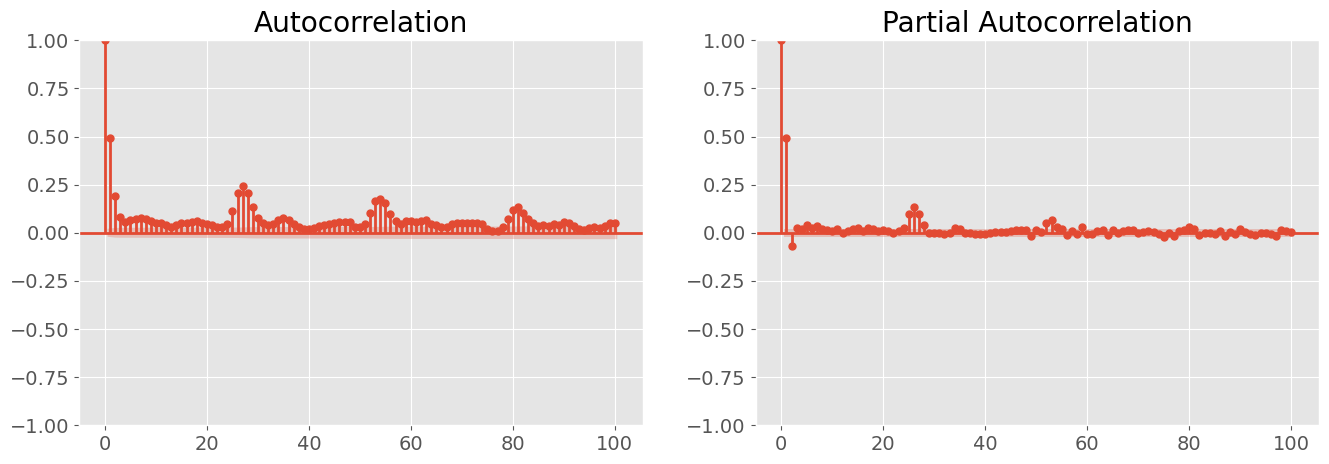

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(daily_max_df_2000["remainder"], lags=100, ax=axes[0])
plot_pacf(daily_max_df_2000["remainder"], lags=100, ax=axes[1]);

Much better with our manual removal, although there seems to be still some autocorrelations at lag 27. 

Let's use the method `STL` to attempt to remove the trends and seasonality. This is a more advanced method of decomposition which stands for Seasonal and Trend decomposition using Loess (locally estimated scatterplot smoothing).

Since the STL method can handle only one seasonality at a time. To address all three, we are going to apply multiple STL decompositions in sequence, removing one seasonal component at a time.

- Step 1: Remove the 27-Day Sun Rotation Seasonality
    - Use STL to decompose the 27-day sun rotation.
    - Subtract the seasonal component from the original data to remove this cycle.
- Step 2: Remove the Yearly (12-Month) Seasonality
    - After removing the 27-day sun rotation, apply another STL decomposition for the 12-month seasonality.
    - Subtract the seasonal component to remove the monthly cycle.
- Step 3: Remove the 11-Year Solar Cycle Seasonality
    - Apply the final STL decomposition for the 11-year solar cycle.
    - Subtract the seasonal component to remove the 11-year cycle.


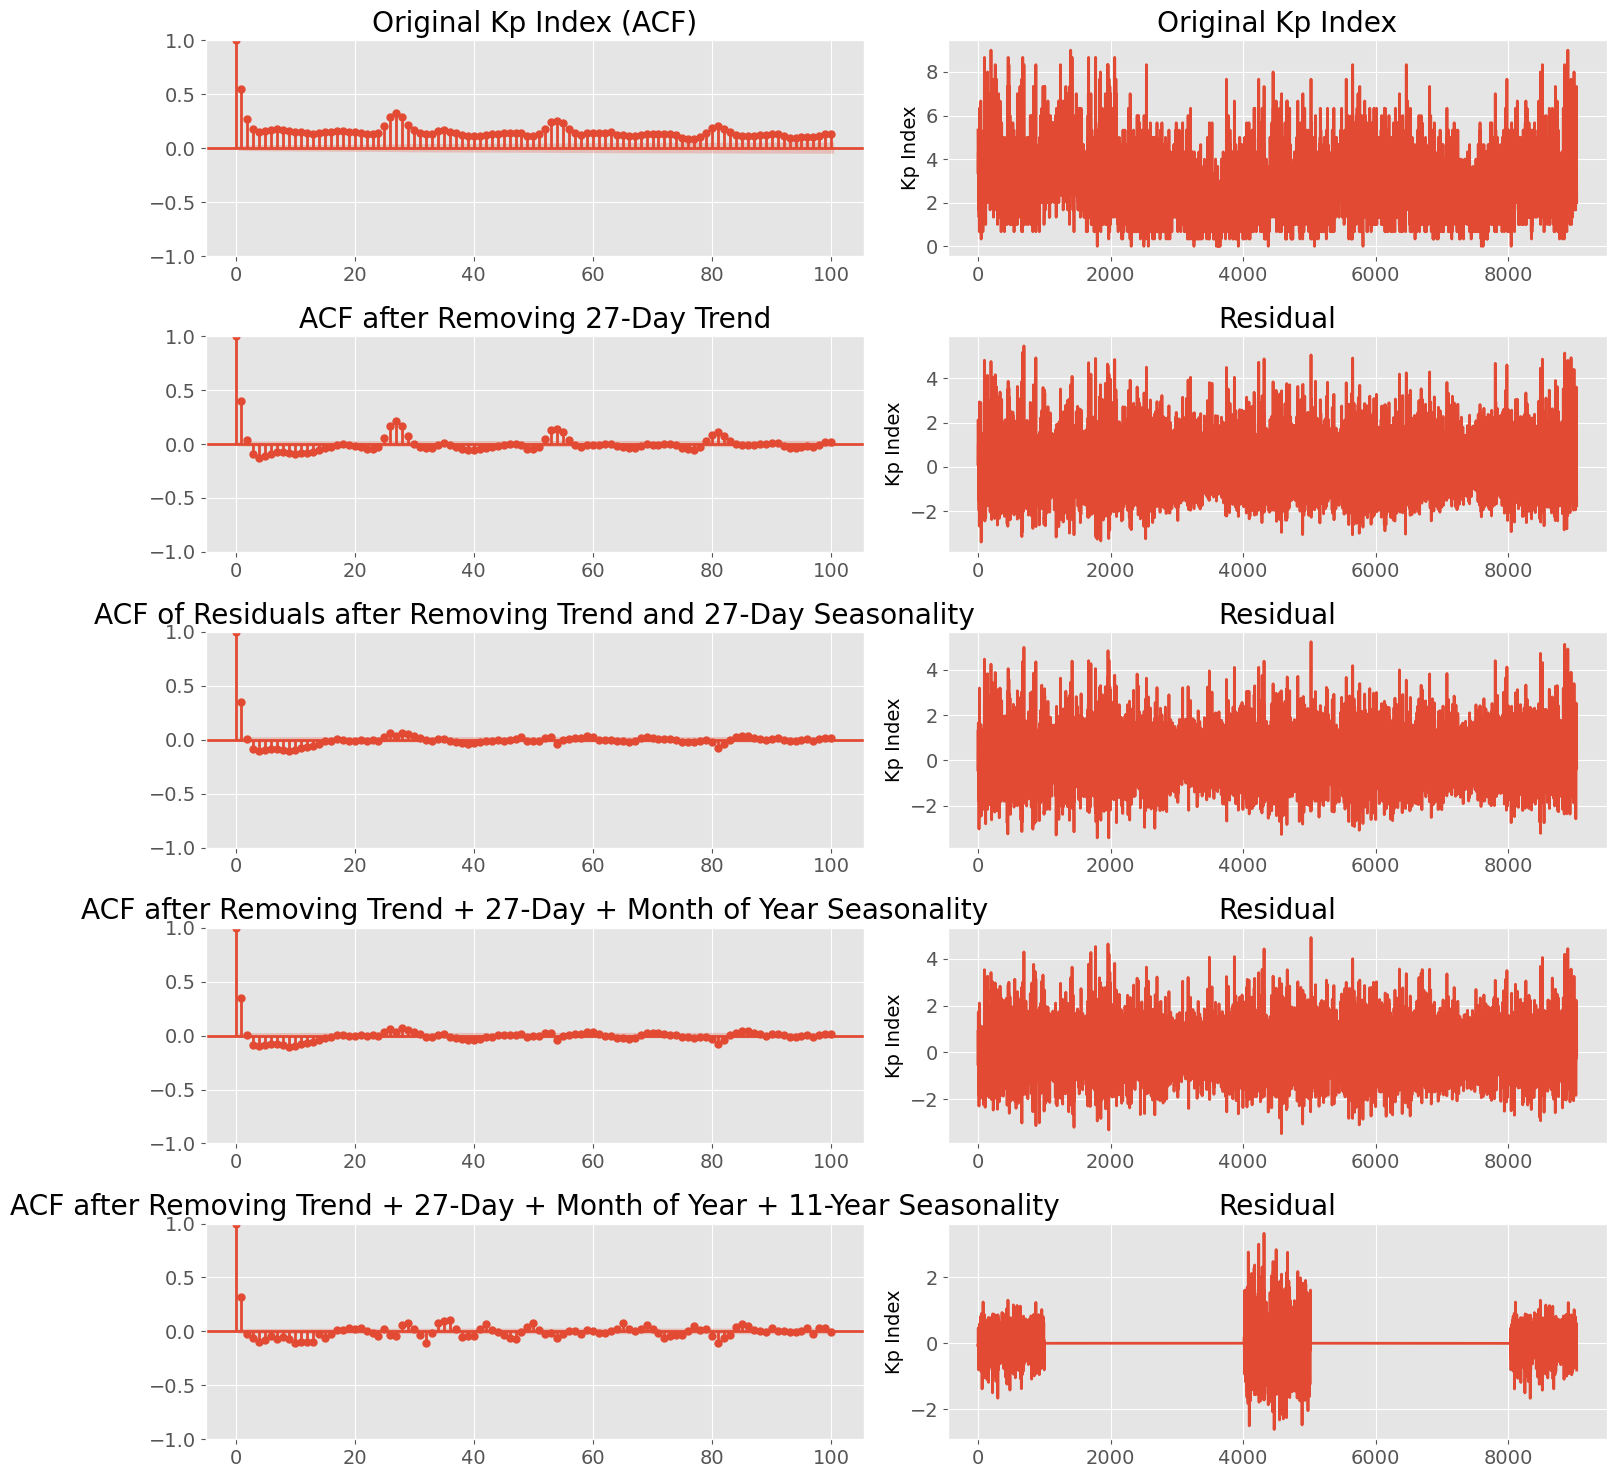

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

# Create subplots with 5 rows and 2 columns: one for ACF plots (left), one for residuals (right)
fig, axes = plt.subplots(5, 2, figsize=(15, 15))

# Step 1: Remove the 27-Day Sun Rotation Trend and Seasonality
stl_27 = STL(daily_max_df_2000['Kp_Index'], period=27, seasonal=27).fit()
daily_max_df_2000['Residual_27'] = daily_max_df_2000['Kp_Index'] - stl_27.trend
daily_max_df_2000['Residual_detrended_27'] = daily_max_df_2000['Residual_27'] - stl_27.seasonal

# Step 2: Remove the Month of Year Seasonality (approximately 365.25 days per year and 30.4 days per month)
days_per_year = int(365.25)
days_per_month = int(days_per_year/12)+1 # Make this 31 as the seasonal parameter requires odd number
stl_monthly = STL(daily_max_df_2000['Residual_detrended_27'], period=days_per_year, seasonal=days_per_month).fit()
daily_max_df_2000['Residual_detrended_27_MoY'] = daily_max_df_2000['Residual_detrended_27'] - stl_monthly.seasonal

# Step 3: Remove the 11-Year Solar Cycle Seasonality
solar_cycle_period = int(11 * days_per_year)  # ~4015 days

stl_11year = STL(daily_max_df_2000['Residual_detrended_27_MoY'], period=solar_cycle_period, seasonal=days_per_year).fit()
daily_max_df_2000['Detrended_Deseasonalized_Kp_Index'] = daily_max_df_2000['Residual_detrended_27_MoY'] - stl_11year.seasonal

# Plot ACF and Residuals side by side

# Original Data
plot_acf(daily_max_df_2000['Kp_Index'], ax=axes[0, 0], lags=100)
axes[0, 0].set_title('Original Kp Index (ACF)')

daily_max_df_2000['Kp_Index'].plot.line(ylabel="Kp Index", title="Original Kp Index", ax=axes[0, 1])

# Step 1: ACF and Residual after removing 27-Day Sun Rotation Seasonality
plot_acf(daily_max_df_2000['Residual_27'], ax=axes[1, 0], lags=100)
axes[1, 0].set_title('ACF after Removing 27-Day Trend')

daily_max_df_2000['Residual_27'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[1, 1])

plot_acf(daily_max_df_2000['Residual_detrended_27'], ax=axes[2,0], lags=100)
axes[2,0].set_title('ACF of Residuals after Removing Trend and 27-Day Seasonality')

daily_max_df_2000['Residual_detrended_27'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[2, 1])

# Step 2: ACF and Residual after removing 27-Day + Month of Year Seasonality
plot_acf(daily_max_df_2000['Residual_detrended_27_MoY'], ax=axes[3, 0], lags=100)
axes[3, 0].set_title('ACF after Removing Trend + 27-Day + Month of Year Seasonality')

daily_max_df_2000['Residual_detrended_27_MoY'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[3, 1])

# Step 3: ACF and Residual after removing 27-Day, Month of Year, and 11-Year Solar Cycle Seasonality
plot_acf(daily_max_df_2000['Detrended_Deseasonalized_Kp_Index'], ax=axes[4, 0], lags=100)
axes[4, 0].set_title('ACF after Removing Trend + 27-Day + Month of Year + 11-Year Seasonality')

daily_max_df_2000['Detrended_Deseasonalized_Kp_Index'].plot.line(ylabel="Kp Index", title="Residual", ax=axes[4, 1])

# Adjust layout
plt.tight_layout()
plt.show()

The detrended and deseasonalized data look very nice. With the residual getting more stationary at each stage. Eventually at the last stage, the residual looks flat. This might due to the 11 year seasonality capturing the data really well, to the point of overfitting even. Or that there leaves little to no variation after removing the 11-year seasonality. 

For our purposes, perhaps we should consider if we need to remove the 11-year seasonality to make the trend completely flat? Perhaps not, we might want data with some variations. 

Thus, for the modelling, let's leave out the 11-year seasonality and go with the first two levels of seasonality removal, which were the 27-days and yearly seasonality. 

In [37]:
daily_max_df_2000['Residual_detrended_27_MoY'].describe()

count    9031.000000
mean        0.000326
std         1.057011
min        -3.473032
25%        -0.727350
50%        -0.067466
75%         0.639327
max         4.916284
Name: Residual_detrended_27_MoY, dtype: float64

Text(0.5, 1.0, 'Rolling std')

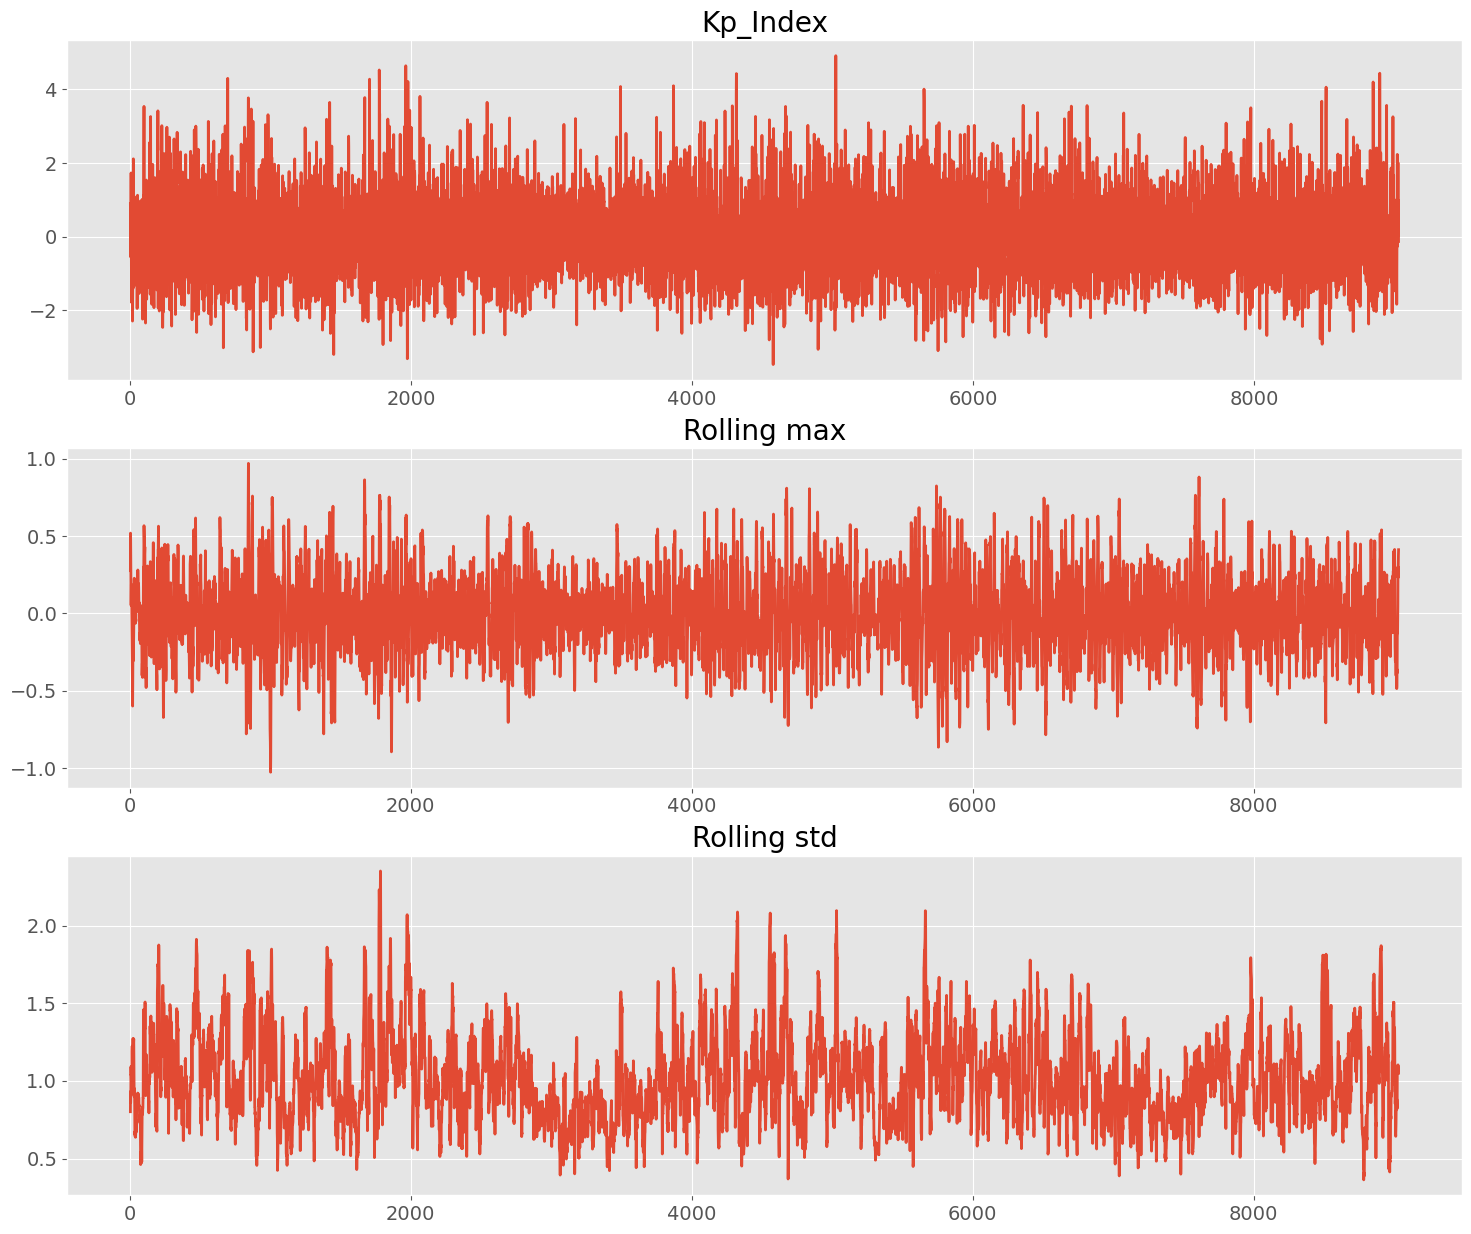

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 15))
wd_size = 14

daily_max_df_2000['Residual_detrended_27_MoY'].plot(ax=axes[0])
axes[0].set_title('Kp_Index')
daily_max_df_2000['Residual_detrended_27_MoY'].rolling(wd_size, min_periods=5).mean().plot(ax=axes[1])
axes[1].set_title('Rolling max')
daily_max_df_2000['Residual_detrended_27_MoY'].rolling(wd_size, min_periods=5).std().plot(ax=axes[2])
axes[2].set_title('Rolling std')

From the rolling mean and standard deviation of the remainder, we can see that the data can be considered stationary now. Let's further employ the Augmented Dickey-Fuller (ADFuller) test to check if the data is stationary. 

In [39]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for original Kp_Index
result_original = adfuller(daily_max_df_2000['Kp_Index'])

# Perform ADF test for detrended residuals
result_detrended = adfuller(daily_max_df_2000['Residual_detrended_27_MoY'])

# Create a DataFrame with ADF statistic and p-values
adf_results = pd.DataFrame({
    'Test': ['Original Kp Index', 'Residual Detrended (27 Days + Month of Year)'],
    'ADF Statistic': [f'{result_original[0]:.2e}', f'{result_detrended[0]:.2e}'],
    'p-value': [f'{result_original[1]:.2e}', f'{result_detrended[1]:.2e}']
})

# Display the DataFrame
adf_results


,Test,ADF Statistic,p-value
0,Original Kp Index,-7.33e+00,1.16e-10
1,Residual Detrended (27 Days + Month of Year),-2.78e+01,0.00e+00


The ADF (Augmented Dickey Fuller) test hypothesizes that the data is non-stationary. Based on the test result, we have enough evidence to reject the null hypothesis (p<0.05).

Let's now clean up the dataset for modeling and forecasting in the next step. 

In [41]:
daily_max_df_2000.columns

Index(['11_Year_Group', 'Day_Sun_rotation', 'Datetime', 'Kp_Index',
       'Poly. fit (order 0)', 'Poly. fit (order 1)', 'Poly. fit (order 2)',
       'detrended', 'Day_of_Month', 'Mean_dayofmonth_peak_Kp',
       'Min_dayofmonth_peak_Kp', 'Max_dayofmonth_peak_Kp', 'Month',
       'Mean_monthly_peak_Kp', 'Min_monthly_peak_Kp', 'Max_monthly_peak_Kp',
       'remainder', 'Day_Sun_rotation_x', 'Year', '11_Year_Group_x',
       'Day_Sun_rotation_y', 'Mean_sunrotation_peak_Kp',
       'Min_sunrotation_peak_Kp', 'Max_sunrotation_peak_Kp', '11_Year_Group_y',
       'Mean_solarcycle_peak_Kp', 'Min_solarcycle_peak_Kp',
       'Max_solarcycle_peak_Kp', 'Residual_27', 'Residual_detrended_27',
       'Residual_detrended_27_MoY', 'Detrended_Deseasonalized_Kp_Index'],
      dtype='object')

In [57]:
daily_max_df_2000_cleaned = daily_max_df_2000.drop(
    columns=[
        "Poly. fit (order 0)",
        "Poly. fit (order 1)",
        "Poly. fit (order 2)",
        "detrended",
        "Min_dayofmonth_peak_Kp",
        "Max_dayofmonth_peak_Kp",
        "Min_monthly_peak_Kp",
        "Max_monthly_peak_Kp",
        "remainder",
        "11_Year_Group_x",
        "Day_Sun_rotation_y",
        "Min_sunrotation_peak_Kp",
        "Max_sunrotation_peak_Kp",
        "11_Year_Group_y",
        "Min_solarcycle_peak_Kp",
        "Max_solarcycle_peak_Kp",
        "Detrended_Deseasonalized_Kp_Index",
    ]
)

daily_max_df_2000_cleaned = daily_max_df_2000_cleaned.rename(columns={"Day_Sun_rotation_x":"Day_Sun_rotation"})

daily_max_df_2000_cleaned.head()

,11_Year_Group,Day_Sun_rotation,Datetime,Kp_Index,Day_of_Month,Mean_dayofmonth_peak_Kp,Month,Mean_monthly_peak_Kp,Day_Sun_rotation,Year,Mean_sunrotation_peak_Kp,Mean_solarcycle_peak_Kp,Residual_27,Residual_detrended_27,Residual_detrended_27_MoY
0,4,1,2000-01-01,5.333,1,3.069596,1,2.788832,1,2000,2.983078,3.130476,2.078821,1.278933,0.891671
1,4,2,2000-01-02,3.333,2,2.900118,1,2.788832,2,2000,3.012973,3.130476,0.076035,-0.475998,-0.025364
2,4,3,2000-01-03,3.333,3,2.780020,1,2.788832,3,2000,2.968164,3.130476,0.072958,-0.467127,-0.550533
3,4,4,2000-01-04,3.667,4,2.919199,1,2.788832,4,2000,2.950257,3.130476,0.403579,0.113897,-0.267605
4,4,5,2000-01-05,4.000,5,2.927017,1,2.788832,5,2000,2.884567,3.130476,0.732885,1.116557,1.335755


# 2. Modeling

In [82]:
# Define our df to contain the observed data.
df_observed = daily_max_df_2000_cleaned[daily_max_df_2000_cleaned['Datetime'] < '2024-01-01'][['Datetime', 'Kp_Index']]
df_observed['Label'] = 'Observed'
df_observed.tail()

,Datetime,Kp_Index,Label
8761,2023-12-27,2.000,Observed
8762,2023-12-28,1.667,Observed
8763,2023-12-29,2.333,Observed
8764,2023-12-30,2.333,Observed
8765,2023-12-31,1.333,Observed


## 2.1 Seasonal naive model (average of Sun Rotation and Month of Year seasonalities)

Work completed up to here.
---

My typical approach is as follows

- Naive (seasonally-adjusted if necessary) / Seasonal naive
- ETS (for SES, or Holt, seasonally-adjust if necessary)
- ARIMA
- ML (next lecture)
- Combinations of the above

In [83]:
# Define the length of sun rotation, which is every 27 days.
days_sun_rotation = 27

# Step 1: Seasonal Naive Model of the 27-days seasonality. We use the last 27-days cycle in 2023 to make prediction for 2024.
seasonal_naive_27 = daily_max_df_2000_cleaned['Kp_Index'][-days_sun_rotation:].reset_index(drop=True)

# Step 2: Seasonal Naive Model for month of the year seasonality. We use the average monthly value from 2023 to make prediction for 2024.
seasonal_naive_month = daily_max_df_2000_cleaned[daily_max_df_2000_cleaned['Year'] == 2023].groupby('Month')['Kp_Index'].mean()

# Step 3: Combine the two models to make prediction for 2024.
combined_seasonal_naive = np.zeros(365)

for i in range(len(combined_seasonal_naive)):
    # Identify the day in sun rotation and the month 
    current_day_sun_rotation = i % 27
    current_month = (pd.Timestamp('2024-01-01') + pd.Timedelta(days=i)).month
    # Location the contribution from the two models
    kp_27_contribution = seasonal_naive_27.iloc[current_day_sun_rotation]
    kp_month_contribution = seasonal_naive_month.loc[current_month]
    # Average of the two models
    combined_seasonal_naive[i] = (kp_27_contribution + kp_month_contribution) / 2

# Step 4: Create a DataFrame for the predictions
naive_preds_df = pd.DataFrame({
    'Datetime': pd.date_range(start='2024-01-01', periods=365, freq='D'),
    'Label': 'Seasonal naive forecast',
    'Kp_Index': combined_seasonal_naive
})

px.line(pd.concat((df_observed, naive_preds_df)), x="Datetime", y="Kp_Index", color="Label", width=1600)

# 2. Modelling

## 2.1 Train-Test Split

Before building our model, we need to split the data into a training set (for model training) and a test set (to evaluate model performance). As for time-series, this has special consideration as 1) we do not shuffle the data to preserve the temporal component and 2) we use a sliding window approach as we have an abundance of data points. 

Training data length: 591
Test data length: 31


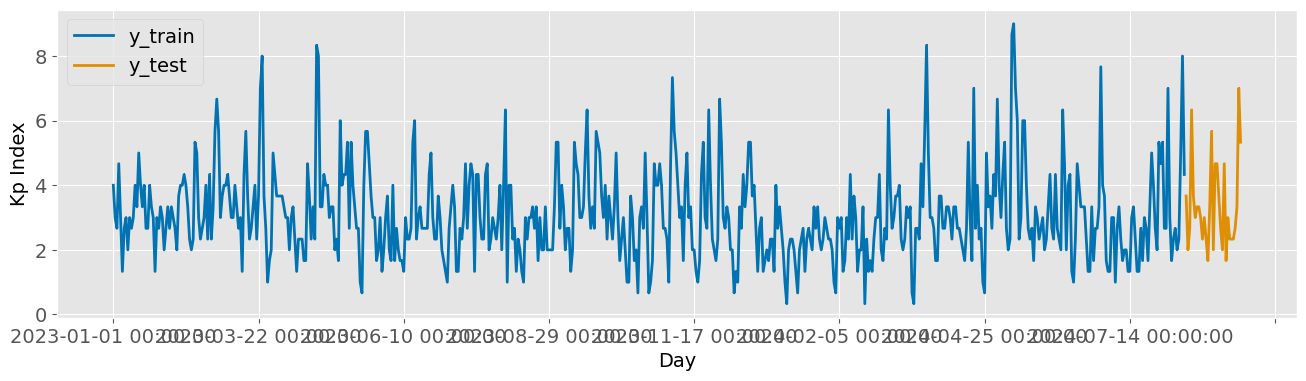

In [50]:
from sktime.forecasting.model_selection import  SlidingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

# y = daily_max_df[['Datetime', 'Kp_Index']].set_index('Datetime')

# Since data much in the past does not tell much about the future, let's only train data from the past two years to save our computational power. 
daily_max_df_short = daily_max_df[(daily_max_df['Datetime'] >= "2023-01-01")]
y = daily_max_df_short[['Datetime', 'Kp_Index']].set_index('Datetime')

# y_train, y_test = temporal_train_test_split(y, test_size = 365)
y_train, y_test = temporal_train_test_split(y, test_size = 31)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"],x_label="Day", y_label="Kp Index", markers=[',',','],)

# Verify the split
print(f"Training data length: {len(y_train)}")
print(f"Test data length: {len(y_test)}")

So in this split, the most recent 1 year (365 days) are used as the test set. Based on the result goes, I may need to adjust this value. 

We now need to define a validation set to help us optimize the model. Remember, the golden rule of machine learning is that the algorithm/model should not see the test set until the very last step to report score. 

In [51]:
# Specify forecast horizon. This has the same length minus one as the test set.
fh = ForecastingHorizon(np.arange(1,len(y_test)))
len(fh)

30

In [55]:
# cv = SlidingWindowSplitter(window_length=4015, step_length=365, fh=fh)

cv = SlidingWindowSplitter(window_length=30, step_length=15, fh=fh)

n_splits = cv.get_n_splits(y_train)
print(f"Number of Folds = {n_splits}")

Number of Folds = 36


In [56]:
from warnings import simplefilter
import seaborn as sns
from matplotlib.ticker import MaxNLocator

def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Train",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Validation",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);
    
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows



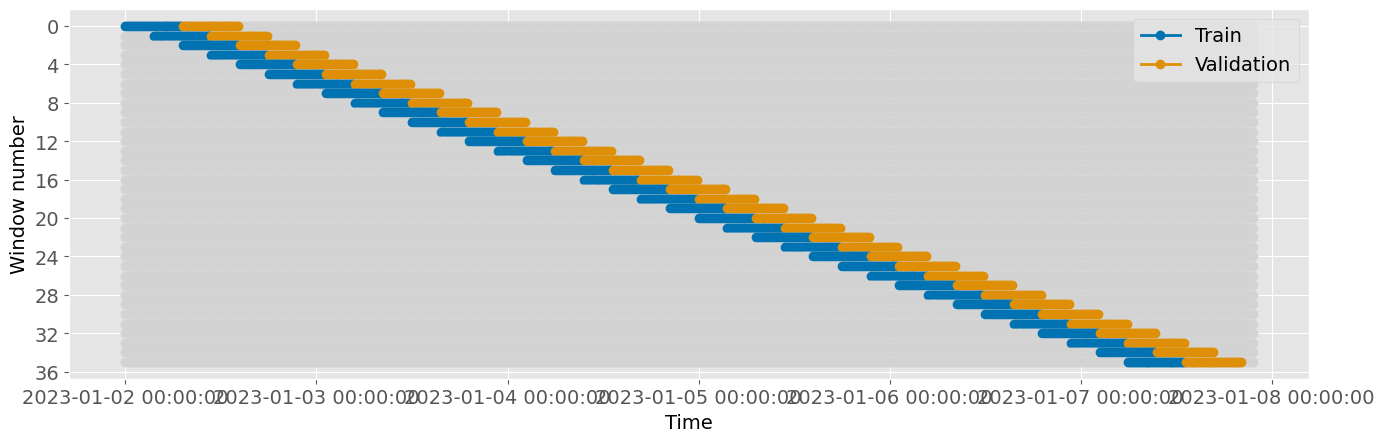

In [57]:
train_windows, test_windows = get_windows(y_train, cv)

plot_windows(y_train, train_windows, test_windows)

To explain how the sliding window works, `window = 4015` indicates that I am using every past 11 years's data to predict the 12th year. The `step_length` indicates that I always skip a year before remaking another prediction. This makes some logical sense as in the EDA section, I showed that in every solar cycle, 11 years, the Kp index repeats. 

## 2.2 Fitting a model

## Baseline models: Naive and Auto-ARIMA
Let's start with a simple baseline model using AutoARIMA.

In [90]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

import pmdarima as pm

autoarima = pm.auto_arima(y_train, start_q=0,start_d=0,start_p=0,
                            max_q=5, max_d=2, max_p=5)
print(autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  591
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -973.720
Date:                Fri, 13 Sep 2024   AIC                           1955.441
Time:                        23:20:22   BIC                           1972.968
Sample:                    01-01-2023   HQIC                          1962.268
                         - 08-13-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5115      0.289      8.678      0.000       1.944       3.079
ar.L1          0.1859      0.090      2.074      0.038       0.010       0.361
ma.L1          0.2925      0.088      3.337      0.0

In [91]:

def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")


def lag_df(df, lag=1, cols=None):
    """Add lagged columns to dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to add lagged columns to.
    lag : int, optional
        How many lagged values to add. By default = 1.
    cols : list, optional
        Columns to lag. By default all columns in df.

    Returns
    -------
    pd.DataFrame
        DataFrame appended with lagged columns.

    Examples
    --------
    >>> pd.DataFrame({'col': [1, 2]})
    >>> lag_df(df, 3)
       col  col-1  col-2  col-3
    0    1    NaN    NaN    NaN
    1    2    1.0    NaN    NaN
    2    3    2.0    1.0    NaN
    3    4    3.0    2.0    1.0
    """
    if cols is None:
        cols = df.columns
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for col in cols for n in range(1, lag + 1)}
    )

In [93]:
pd.concat((y_train, y_test, autoarima_pred))

,Kp_Index,Label
2023-01-01,4.000000,NaN
2023-01-02,3.000000,NaN
2023-01-03,2.667000,NaN
2023-01-04,4.667000,NaN
2023-01-05,3.000000,NaN
...,...,...
2024-09-08,3.084867,"AUTO_ARIMA(1,0,1) fit"
2024-09-09,3.084867,"AUTO_ARIMA(1,0,1) fit"
2024-09-10,3.084867,"AUTO_ARIMA(1,0,1) fit"
2024-09-11,3.084867,"AUTO_ARIMA(1,0,1) fit"


In [92]:
forecast_index = create_forecast_index(y_train.index[-1], 30, freq="D")

autoarima_pred = pd.DataFrame({"Kp_Index": autoarima.predict(len(forecast_index)),
                      "Label": "AUTO_ARIMA(1,0,1) fit"},
                     index=forecast_index).iloc[1:]
fig = px.line(pd.concat((y_train, y_test, autoarima_pred)), y="Kp_Index", width = 640, color="Label")
fig

In [62]:
forecaster = NaiveForecaster(strategy="last", sp=27) # seasonal period
results = evaluate(forecaster=forecaster, y=y_train, cv=cv, strategy="refit", return_data=True)
results

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,NaN,0.001916,NaN,30,NaT,Kp_Index 2023-01-01 4.000 2023...,Kp_Index 2023-01-31 3.333 2023...,NaN
1,NaN,0.001339,NaN,30,NaT,Kp_Index 2023-01-16 4.000 2023...,Kp_Index 2023-02-15 5.333 2023...,NaN
2,NaN,0.002919,NaN,30,NaT,Kp_Index 2023-01-31 3.333 2023...,Kp_Index 2023-03-02 3.667 2023...,NaN
3,NaN,0.001199,NaN,30,NaT,Kp_Index 2023-02-15 5.333 2023...,Kp_Index 2023-03-17 2.333 2023...,NaN
4,NaN,0.004953,NaN,30,NaT,Kp_Index 2023-03-02 3.667 2023...,Kp_Index 2023-04-01 3.667 2023...,NaN
5,NaN,0.031485,NaN,30,NaT,Kp_Index 2023-03-17 2.333 2023...,Kp_Index 2023-04-16 1.667 2023...,NaN
6,NaN,0.000978,NaN,30,NaT,Kp_Index 2023-04-01 3.667 2023...,Kp_Index 2023-05-01 3.333 2023...,NaN
7,NaN,0.002549,NaN,30,NaT,Kp_Index 2023-04-16 1.667 2023...,Kp_Index 2023-05-16 2.667 2023...,NaN
8,NaN,0.003734,NaN,30,NaT,Kp_Index 2023-05-01 3.333 2023...,Kp_Index 2023-05-31 3.000 2023...,NaN
9,NaN,0.000877,NaN,30,NaT,Kp_Index 2023-05-16 2.667 2023...,Kp_Index 2023-06-15 5.333 2023...,NaN


SlidingWindowSplitter(fh=ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
           dtype='int64', is_relative=True),
                      step_length=15, window_length=30)